# Tarea 1: procesamiento de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# cargar datos
data00 = pd.read_csv('https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_01/data/CWRU_48k_DE000.csv')
print('healthy shape {}'.format(data00.shape))
data07 = pd.read_csv('https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_01/data/CWRU_48k_DE007.csv')
print('07 shape {}'.format(data07.shape))
data14 = pd.read_csv('https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_01/data/CWRU_48k_DE014.csv')
print('14 shape {}'.format(data14.shape))
data21 = pd.read_csv('https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_01/data/CWRU_48k_DE021.csv')
print('21 shape {}'.format(data21.shape))

data = pd.concat([data00, data07, data14, data21], axis=1)

print(data.shape)
data.head()

healthy shape (288000, 1)
07 shape (288000, 3)
14 shape (288000, 3)
21 shape (288000, 3)
(288000, 10)


,Healthy,IR007,B007,OR007,IR014,B014,OR014,IR021,B021,OR021
0,0.046104,0.032127,-0.041097,0.084719,-0.010016,-0.463543,0.133305,1.121099,-0.061959,0.040064
1,-0.037134,0.078231,-0.046104,0.694860,-0.002921,-0.475852,0.152498,0.783351,-0.037551,0.021701
2,-0.089496,0.161468,-0.028372,1.159769,0.005425,-0.418065,0.166475,0.391571,-0.017941,-0.020867
3,-0.084906,0.250547,0.001252,1.397232,0.017528,-0.313966,0.148534,-0.060498,0.019401,-0.065104
4,-0.038594,0.315426,0.033796,1.413508,0.021284,-0.171482,0.112652,-0.502972,0.049650,-0.111845


In [9]:
def get_time_windows(data, nperwd, nleap):
  """
  -> np.array

  generates a numpy array of time windows, of length nperwd, extracted
  from data.

  :param pd.Series data:
    time series of measurement values.
  :param int nperwd:
    length of samples of each time window.
  :param int nleap:
    length of leap between time windows.

  :returns:
    a numpy array of size (n_windows, nperwd).
  """

  # obtener np.array de la serie de datos
  x = data.values
  n_data = x.shape[0]
  
  # determinar cantidad de ventanas a generar
  n_windows = np.floor( (n_data - nperwd)/nleap ) + 1
  n_windows = int(n_windows)

  # inicializar dataset
  X = np.zeros( (n_windows, nperwd, x.shape[1]) )
  
  # generar time windows
  for i in range(n_windows):
    # obtener index de la ventana
    idx_start, idx_end = i*nleap, i*nleap + nperwd

    # asignar datos a X
    X[i, :, :] = x[idx_start:idx_end,:]
  
  return X


train (207361, 10), validation (51841, 10) and test (28800, 10) shapes
train windows 4933
val windows 1230
test windows 681


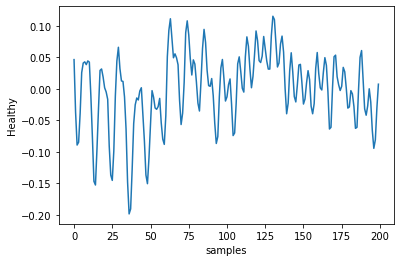

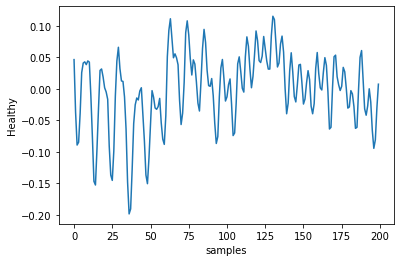

In [28]:
# dividir los datos para evitar el data leak
n_train = int(0.9 * data.shape[0])
train_data = data.loc[:n_train,:]
test_data = data.loc[n_train:,:]

n_train = int(0.8 * train_data.shape[0])
val_data = train_data.loc[n_train:,:]
train_data = train_data.loc[:n_train,:]

print('train {}, validation {} and test {} shapes'.format(train_data.shape,
                                                          val_data.shape,
                                                          test_data.shape))

nperwd = 200
nleap = 42

X_train = get_time_windows(train_data, nperwd, nleap)
print('train windows {}'.format(X_train.shape[0]))
X_val = get_time_windows(val_data, nperwd, nleap)
print('val windows {}'.format(X_val.shape[0]))
X_test = get_time_windows(test_data, nperwd, nleap)
print('test windows {}'.format(X_test.shape[0]))

plt.plot(X_train[0,:,0])
plt.xlabel('samples'), plt.ylabel('Healthy')
plt.show()

plt.plot(train_data.loc[:,'Healthy'][:nperwd])
plt.xlabel('samples'), plt.ylabel('Healthy')
plt.show()


In [29]:
from keras.utils import to_categorical

# generar np.array Y_train con las etiquetas correspondientes
def toCategorical(df):
  Y = []
  for y, c in enumerate(df):
    Y.append([y] * df[c].shape[0])
  Y = np.concatenate(Y)
  return to_categorical(Y, num_classes=10)

def crearDF(X):
  df = {'Healthy':   X[:,:,0],
        'IR07':      X[:,:,1],
        'B07':       X[:,:,2],
        'OR07':      X[:,:,3],
        'IR14':      X[:,:,4],
        'B14':       X[:,:,5],
        'OR14':      X[:,:,6],
        'IR21':      X[:,:,7],
        'B21':       X[:,:,8],
        'OR21':      X[:,:,9]}
  return df


In [18]:
Y_train = toCategorical(crearDF(X_train))
Y_val = toCategorical(crearDF(X_val))
Y_test = toCategorical(crearDF(X_test))

print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)


(49330, 10)
(12300, 10)
(6810, 10)


In [34]:
X_train = np.vstack([X_train[:,:,i] for i in range(10)])
X_val = np.vstack([X_val[:,:,i] for i in range(10)])
X_test = np.vstack([X_test[:,:,i] for i in range(10)])

(49330, 200)


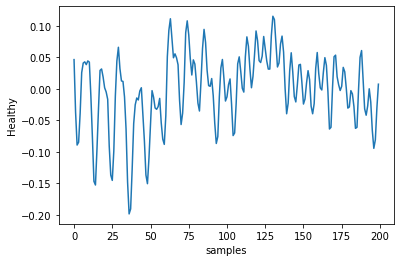

In [36]:
print(X_train.shape)

plt.plot(X_train[0,:])
plt.xlabel('samples'), plt.ylabel('Healthy')
plt.show()

In [47]:
from scipy.stats import kurtosis
from scipy.stats import skew

def extract_features(x):
  """
  -> np.array

  compute 9 signal features for each sample along the data x:
  - mean, variance.
  - rms, peak, valley, peak2peak.
  - crest factor, kurtosis, skewness.

  :param np.array x:
    data of shape (n_samples, nperwd) containing de samples.

  :returns:
    np.ndarray of shape (n_samples, n_features) containing
    the extracted features.
  """

  # mean
  mean = np.mean( x, axis=1 )
  mean = mean.reshape( (-1, 1) )

  # varianza
  var = np.var( x, axis=1 )
  var = var.reshape( (-1, 1) )

  # -----------------------------------------------------------
  # valor eficaz rms
  rms = np.sqrt( np.mean( np.square(x), axis=1 ) )
  rms = rms.reshape( (-1, 1) )

  # peak
  peak = np.reshape( np.max( x, axis=1 ), (-1, 1) )

  # valley
  valley = np.reshape( np.min( x, axis=1 ), (-1, 1) )

  # peak2peak
  p2p = np.reshape( np.abs( peak - valley ), (-1, 1) )
Como que me hice un arreglo de las ventanas
  # -----------------------------------------------------------
  # crest factor
  cf = np.divide( peak, rms )

  # kurtosis
  ktsis = np.reshape( kurtosis( x, axis=1 ), (-1, 1) )

  # skewness
  skwn = np.reshape( skew( x, axis=1 ), (-1, 1) )

  # -----------------------------------------------------------
  # concatenar features
  out = np.hstack( [mean, var, rms, peak, valley, p2p, cf, ktsis, skwn] )
  return out

def extract_featuresAll(X):
  """
  sacar diff e integral para luego extraer sus caracteristicas con 
  extract_features
  """
  
  x_diff = np.diff(X, axis=1)
  x_int = np.cumsum(X, axis=1)
  
  f_diff = extract_features(x_diff)
  f_int = extract_features(x_int)
  f = extract_features(X)


  return np.hstack([f, f_diff, f_int])

(49330, 27)
(12300, 27)
(6810, 27)


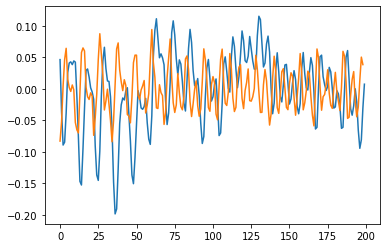

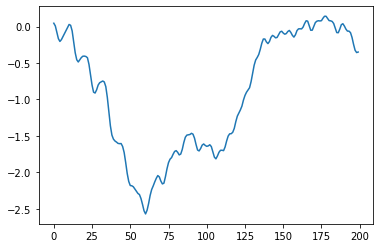

In [50]:
# obtener features de las series de tiempo
train_features = extract_featuresAll(X_train)
val_features = extract_featuresAll(X_val)
test_features = extract_featuresAll(X_test)

print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

plt.plot(X_train[0])
plt.plot(np.diff(X_train, axis=1)[0])
plt.show()
plt.plot(np.cumsum(X_train, axis=1)[0])
plt.show()


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense

# inicializar modelo keras.Sequential
model = Sequential()

# ahora podemos ir agregando secuencialmente capas nuestro modelo
# mediante el método keras.Model.add

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
input_dim = (27, )
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Dense.
# https://keras.io/api/layers/core_layers/dense/

# las keras.layers.Dense reciben la cantidad de nodos o units dentro
# de la capa y la función de activación que operarán.
# https://keras.io/api/layers/activations/

model.add( Dense(units=32, activation='relu') )
model.add( Dense(units=32, activation='relu') )

# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas o estados de salud.
labels_num = 3
model.add( Dense(units=labels_num, activation='softmax') )